<a href="https://colab.research.google.com/github/mahtab2/Medical-Image-Segmentation/blob/main/Bowl_Medical_image_segmentation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
 
# Accessing My Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Preprequisites

In [2]:
pip uninstall opencv-python-headless==4.5.5.62

In [3]:
pip install opencv-python-headless==4.1.2.30

     |████████████████████████████████| 21.8 MB 1.4 MB/s 


In [4]:
import tensorflow as tf
import os
import numpy as np
import cv2
import json
from tqdm import tqdm
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

# Helper functions

In [5]:
def create_dir(path):
    # Create a directory.
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:
        print(f"Error: creating directory with name {path}")

def read_data(x, y):
    # Read the image and mask from the given path.
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    mask = cv2.imread(y, cv2.IMREAD_COLOR)
    return image, mask

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def read_image(x):
    x = x.decode()
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = np.clip(image - np.median(image)+127, 0, 255)
    image = image/255.0
    image = image.astype(np.float32)
    return image

def read_mask(y):
    y = y.decode()
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = mask/255.0
    mask = mask.astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)
    return mask

def read_mask3(y):
    # y = y.decode()
    mask = cv2.imread(y, cv2.IMREAD_COLOR)
    # mask = mask/255.0
    # mask = mask.astype(np.float32)
    # mask = np.expand_dims(cv2.resize(mask, (512, 384)), axis=-1)
    mask = cv2.resize(mask, (512, 384))
    # plt.imshow(cv2.cvtColor(mask, cv2.IMREAD_COLOR))
    return mask

def read_mask2(path):
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
    index = 0
    for mask_file in next(os.walk(path + '/masks/'))[2]:
      # print(mask_file)
      if index == 0:
        # print("inja")
        mask = read_mask3(path + '/masks/' + mask_file)
        index +=1
      else:
        
        # mask_ = cv2.imread(path + '/masks/' + mask_file, cv2.IMREAD_GRAYSCALE)
        # mask = mask/255.0
        # # mask = mask.astype(np.float32)
        # mask_ = np.expand_dims(cv2.resize(mask_, (512, 384)), axis=-1)
        mask_ = read_mask3(path + '/masks/' + mask_file)
        mask = np.maximum(mask, mask_)
    # print(mask.shape)
    mask = cv2.resize(mask, (512,384))
    return mask

def read_data2(path, id):
    image = cv2.imread(path + '/images/' + id + '.png')[:,:,:3]
    # image = np.clip(image - np.median(image)+127, 0, 255)
    # image = image/255.0
    # image = image.astype(np.float32)
    image = cv2.resize(image, (512,384))
    mask = read_mask2(path)
    return image, mask

# Data

In [35]:
! mkdir data

## Bowl 2018 challenge

In [36]:
!pip install kaggle
!mkdir .kaggle

In [37]:
! pip install -q kaggle
from google.colab import files

In [38]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mahtab99","key":"275ce79068503b70fe1e88b1ef53cd77"}'}

In [ ]:
! rm -r ~/.kaggle

In [39]:
! mkdir ~/.kaggle

In [40]:
! cp kaggle.json ~/.kaggle/

In [41]:
! chmod 600 ~/.kaggle/kaggle.json

In [42]:
! kaggle datasets list

ref                                                            title                                              size  lastUpdated          downloadCount  
-------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
yasserh/wine-quality-dataset                                   Wine Quality Dataset                               21KB  2022-01-15 19:15:11           7096  
prasertk/netflix-subscription-price-in-different-countries     Netflix subscription fee in different countries     3KB  2022-01-15 07:06:09           5422  
prasertk/the-best-cities-for-a-workation                       The Best Cities for a Workation                     6KB  2022-02-16 11:46:28            618  
majyhain/height-of-male-and-female-by-country-2022             Height of Male and Female by Country 2022           4KB  2022-02-02 00:40:19           2680  
sanjeetsinghnaik/top-1000-highest-grossing-movies         

In [43]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 3.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=ec1427c46cce4f57707cb9774390ce1b7896ccda35df6390977d33716bd9f311
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [44]:
! kaggle competitions download -c data-science-bowl-2018

 97% 346M/358M [00:02<00:00, 163MB/s]
100% 358M/358M [00:02<00:00, 134MB/s]


In [45]:
! unzip data-science-bowl-2018

Archive:  data-science-bowl-2018.zip
  inflating: stage1_sample_submission.csv.zip  
  inflating: stage1_solution.csv.zip  
  inflating: stage1_test.zip         
  inflating: stage1_train.zip        
  inflating: stage1_train_labels.csv.zip  
  inflating: stage2_sample_submission_final.csv.zip  
  inflating: stage2_test_final.zip   


In [46]:
! mkdir bowl

In [ ]:
rm -r bowl

In [47]:
! unzip stage1_train.zip -d stage1_train

Streaming output truncated to the last 5000 lines.
  inflating: stage1_train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/160cf18b03df69978e2ed33335afcd781ebebf4ee42df566aaa6fd0aee66ac93.png  
  inflating: stage1_train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/16d3bf2426e9cda0e4f435de3a0c260d17be460f1c834c1282dfd68f9fcf7509.png  
  inflating: stage1_train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/1cfe69ef1dec8963e05ba8386a956af0073ba0bec2cc8ba534df81ef6dee905a.png  
  inflating: stage1_train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/1d2543cd2a8134ac2ca091a230bd15270826f8dd83c6594550b7f0fc85a15f8e.png  
  inflating: stage1_train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/24b50e6e3406e513d47ddfa9bd85505a95a266858cffc730a9ad7bc99936b800.png  
  inflating: stage1_train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/341193ff7f03

In [48]:
! unzip stage1_test.zip -d stage1_test

Archive:  stage1_test.zip
   creating: stage1_test/0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5/
   creating: stage1_test/0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac/
   creating: stage1_test/0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732/
   creating: stage1_test/0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925/
   creating: stage1_test/0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6/
   creating: stage1_test/0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466/
   creating: stage1_test/1747f62148a919c8feb6d607faeebdf504b5e2ad42b6b1710b1189c37ebcdb2c/
   creating: stage1_test/17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff/
   creating: stage1_test/1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b/
   creating: stage1_test/191b2b2205f2f5cc9da04702c5d422bc249faf8bca1107af792da63cccfba829/
   creating: stage1_test/1962d0c5faf3e85cda80e0578e0cb7aca50826d

In [49]:
# Set some parameters
# IMG_WIDTH = 256
# IMG_HEIGHT = 256
# IMG_CHANNELS = 3
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

In [50]:
images_ids = next(os.walk(TRAIN_PATH))[1]
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 384, 512, 3

In [51]:
import sys
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import random
import matplotlib.pyplot as plt

In [52]:
root = './stage1_train/'

In [53]:
X = np.zeros((len(images_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(images_ids), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
# print(X.shape)
# print(Y.shape)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(images_ids[0:5]), total=5):
    
    # print(path)
    # img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    # img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    # img = cv2.imread(path + '/images/' + id_ + '.png', cv2.IMREAD_COLOR)
    # img = cv2.resize(img, (512,384))
    
    path = root + id_
    print(n)
    print(path)
    img, mask = read_data2(path, id_)
    X[n] = img
    # print(mask)
    # print(mask.shape)
    # plt.imshow(mask)
    Y[n] = mask
    # mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    # for mask_file in next(os.walk(path + '/masks/'))[2]:
    #     mask_ = cv2.imread(path + '/masks/' + mask_file, cv2.IMREAD_GRAYSCALE)
    #     mask_ = np.expand_dims(cv2.resize(mask_, (512, 384)), axis=-1)
    #     mask = np.maximum(mask, mask_)
    

Getting and resizing train images and masks ... 


 20%|██        | 1/5 [00:00<00:00,  9.46it/s]

0
./stage1_train/88678981648b184b23b6c04999f29210cbe351f85b61d2bf99e306fd67a2998a
1
./stage1_train/e5a7b8a9924b26b3abf039255a8a3bb00258f4966f68ff3349560b4350af9367


 40%|████      | 2/5 [00:00<00:00,  6.05it/s]

2
./stage1_train/1a11552569160f0b1ea10bedbd628ce6c14f29edec5092034c2309c556df833e


100%|██████████| 5/5 [00:01<00:00,  4.33it/s]

3
./stage1_train/a6515d73077866808ad4cb837ecdac33612527b8a1041e82135e40fce2bb9380
4
./stage1_train/b3a9f4c9035a0df7e033b18c63bfb0f0d87ff5a4d9aa8bdf417159bb733abb80


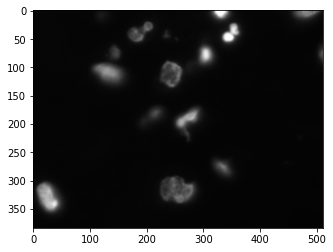

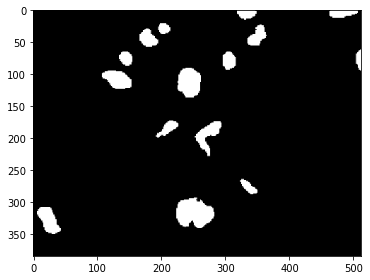

In [54]:
ix = random.randint(0, len(images_ids)//5)
# imshow(X[ix])
plt.imshow(cv2.cvtColor(X[3], cv2.COLOR_BGR2RGB))
plt.show()
imshow(Y[3])
# imshow(np.squeeze(Y[0]))
plt.show()

# Pre Processing

## Augmentation

In [55]:
! pip install -U albumentations

In [56]:
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,
    CenterCrop,
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion,
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,
    RandomGamma,
    HueSaturationValue,
    RGBShift,
    RandomBrightness,
    RandomContrast,
    MotionBlur,
    MedianBlur,
    GaussianBlur,
    GaussNoise,
    ChannelShuffle,
    CoarseDropout
)
import albumentations as A

In [57]:
# X = []
# Y = []
# for n, ids_ in tqdm(enumerate(images_ids[0:6]), total=6):
#   path = root + ids_
#   print(path)
#   x, y = read_data2(path,ids_)
#   X.append(x)
#   Y.append(y)

In [58]:
  # plt.imshow(X[2])
  # plt.show()
  # plt.imshow(Y[2])
  # plt.show()

In [59]:
def augment_data(images_ids, save_path, augment=True):
    """ Performing data augmentation. """
    crop_size = (192-32, 256-32)
    size = (512, 384)
    # size = (384, 288)

    for n, ids_ in tqdm(enumerate(images_ids), total=len(images_ids)):
        image_name = ids_
        mask_name = ids_
        path = root + ids_

        x, y = read_data2(path,ids_)
        x = cv2.resize(x, size)
        y = cv2.resize(y, size)
        # y = np.squeeze(y)
        # print(x.shape)
        # print(y.shape)

        # try:
        #     h, w, c = x.shape
        # except Exception as e:
        #     image = image[:-1]
        #     x, y = read_data2(path)
        #     h, w, c = x.shape

        if augment == True:

            ## Center Crop
            aug = A.CenterCrop(p=1.0, height=crop_size[0], width=crop_size[1])
            augmented = aug(image=x, mask=y)
            x1 = augmented['image']
            y1 = augmented['mask']

            ## Crop
            x_min = 0
            y_min = 0
            x_max = x_min + size[0]
            y_max = y_min + size[1]

            aug = A.Crop(p=1, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
            augmented = aug(image=x, mask=y)
            x2 = augmented['image']
            y2 = augmented['mask']

            ## Random Rotate 90 degree
            aug = A.RandomRotate90(p=1)
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']

            ## Transpose
            aug = A.Transpose(p=1)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']

            ## ElasticTransform
            aug = A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
            augmented = aug(image=x, mask=y)
            x5 = augmented['image']
            y5 = augmented['mask']

            ## Grid Distortion
            aug = A.GridDistortion(p=1)
            augmented = aug(image=x, mask=y)
            x6 = augmented['image']
            y6 = augmented['mask']

            ## Optical Distortion
            aug = A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)
            augmented = aug(image=x, mask=y)
            x7 = augmented['image']
            y7 = augmented['mask']

            ## Vertical Flip
            aug = A.VerticalFlip(p=1)
            augmented = aug(image=x, mask=y)
            x8 = augmented['image']
            y8 = augmented['mask']

            ## Horizontal Flip
            aug = A.HorizontalFlip(p=1)
            augmented = aug(image=x, mask=y)
            x9 = augmented['image']
            y9 = augmented['mask']

            ## Grayscale
            x10 = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
            y10 = y

            ## Grayscale Vertical Flip
            aug = A.VerticalFlip(p=1)
            augmented = aug(image=x10, mask=y10)
            x11 = augmented['image']
            y11 = augmented['mask']

            ## Grayscale Horizontal Flip
            aug = A.HorizontalFlip(p=1)
            augmented = aug(image=x10, mask=y10)
            x12 = augmented['image']
            y12 = augmented['mask']

            ## Grayscale Center Crop
            aug = A.CenterCrop(p=1, height=crop_size[0], width=crop_size[1])
            augmented = aug(image=x10, mask=y10)
            x13 = augmented['image']
            y13 = augmented['mask']

            ##
            aug = A.RandomBrightnessContrast(p=1)
            augmented = aug(image=x, mask=y)
            x14 = augmented['image']
            y14 = augmented['mask']

            aug = A.RandomGamma(p=1)
            augmented = aug(image=x, mask=y)
            x15 = augmented['image']
            y15 = augmented['mask']

            aug = A.HueSaturationValue(p=1)
            augmented = aug(image=x, mask=y)
            x16 = augmented['image']
            y16 = augmented['mask']

            aug = A.RGBShift(p=1)
            augmented = aug(image=x, mask=y)
            x17 = augmented['image']
            y17 = augmented['mask']

            aug = A.RandomBrightness(p=1)
            augmented = aug(image=x, mask=y)
            x18 = augmented['image']
            y18 = augmented['mask']

            aug = A.RandomContrast(p=1)
            augmented = aug(image=x, mask=y)
            x19 = augmented['image']
            y19 = augmented['mask']

            aug = A.MotionBlur(p=1, blur_limit=7)
            augmented = aug(image=x, mask=y)
            x20 = augmented['image']
            y20 = augmented['mask']

            aug = A.MedianBlur(p=1, blur_limit=9)
            augmented = aug(image=x, mask=y)
            x21 = augmented['image']
            y21 = augmented['mask']

            aug = A.GaussianBlur(p=1, blur_limit=9)
            augmented = aug(image=x, mask=y)
            x22 = augmented['image']
            y22 = augmented['mask']

            aug = A.GaussNoise(p=1)
            augmented = aug(image=x, mask=y)
            x23 = augmented['image']
            y23 = augmented['mask']

            aug = A.ChannelShuffle(p=1)
            augmented = aug(image=x, mask=y)
            x24 = augmented['image']
            y24 = augmented['mask']

            aug = A.CoarseDropout(p=1, max_holes=8, max_height=32, max_width=32)
            augmented = aug(image=x, mask=y)
            x25 = augmented['image']
            y25 = augmented['mask']

            images = [
                x, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10,
                x11, x12, x13, x14, x15, x16, x17, x18, x19, x20,
                x21, x22, x23, x24, x25
            ]
            masks  = [
                y, y1, y2, y3, y4, y5, y6, y7, y8, y9, y10,
                y11, y12, y13, y14, y15, y16, y17, y18, y19, y20,
                y21, y22, y23, y24, y25
            ]

        else:
            images = [x]
            masks  = [y]

        idx = 0
        for i, m in zip(images, masks):
            i = cv2.resize(i, size)
            m = cv2.resize(m, size)
            # print('inja', i.shape)

            tmp_image_name = f"{image_name}_{idx}.jpg"
            tmp_mask_name  = f"{mask_name}_{idx}.jpg"

            image_path = os.path.join(save_path, "image/", tmp_image_name)
            mask_path  = os.path.join(save_path, "mask/", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx += 1


## Split

In [60]:
def load_data(images_ids, split=0.1):

    len_ids = len(images_ids)
    train_size = int((80/100)*len_ids)
    valid_size = int((10/100)*len_ids)		## Here 10 is the percent of images used for validation
    test_size = int((10/100)*len_ids)		## Here 10 is the percent of images used for testing

    train_x, test_x = train_test_split(images_ids, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(images_ids, test_size=test_size, random_state=42)

    train_x, valid_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, valid_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return  (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [61]:
def split_augment_data(path,images_ids):
    np.random.seed(42)
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(images_ids, split=0.1)

    create_dir(path + "/new_data1/train/image/")
    create_dir(path + "/new_data1/train/mask/")
    create_dir(path + "/new_data1/valid/image/")
    create_dir(path + "/new_data1/valid/mask/")
    create_dir(path + "/new_data1/test/image/")
    create_dir(path + "/new_data1/test/mask/")

    print("here")

    augment_data(train_x, path + "/new_data1/train/", augment=True)
    augment_data(valid_x, path + "/new_data1/valid/", augment=False)
    augment_data(test_x, path + "/new_data1/test/", augment=False)

## Visualisation

In [17]:
aug_list = ["original",
            "Center Crop" , 
            "Crop",
            "Random Rotate 90 degree",
            "Transpose", 
             "ElasticTransform",
             "Grid Distortion",
             "Optical Distortion",
            "Vertical Flip",
            "Horizontal Flip",
            "Grayscale",
            "Grayscale Vertical Flip",
            "Grayscale Horizontal Flip",
            "Grayscale Center Crop",
            "RandomBrightnessContrast",
            "RandomGamma",
            "HueSaturationValue",
            "RGBShift",
            "RandomBrightness",
            "RandomContrast",
            "MotionBlur",
            "MedianBlur",
            "GaussianBlur",
            "GaussNoise",
            "ChannelShuffle",
            "CoarseDropout"
            ]

In [18]:
len(aug_list)

26

In [19]:
def visualise_augmentation(path):

    img_path = glob(os.path.join(path, "image/*"))
    msk_path = glob(os.path.join(path, "mask/*"))

    img_path.sort()
    msk_path.sort()

    
    rows = 1
    columns = 2
    for i in range(0,26):
      fig = plt.figure(figsize=(8, 8))
      fig.add_subplot(rows, columns,  1)
      img = cv2.imread(img_path[i], cv2.IMREAD_COLOR)
      plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      plt.axis('off')
      plt.title(aug_list[i])
 
      fig.add_subplot(rows, columns, 2)
      msk = cv2.imread(msk_path[i], cv2.IMREAD_COLOR)
      plt.imshow(cv2.cvtColor(msk, cv2.COLOR_BGR2RGB))
      plt.axis('off')
      plt.title(aug_list[i])



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


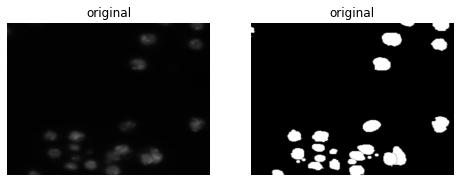

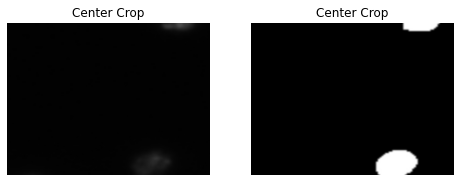

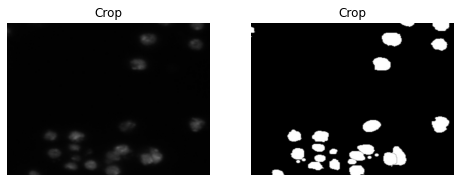

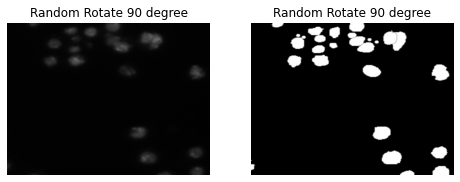

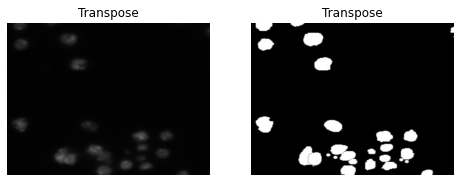

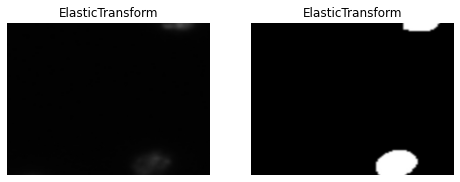

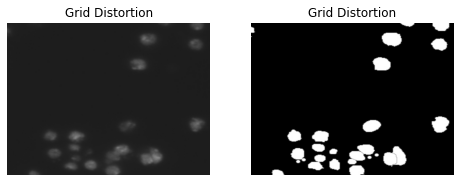

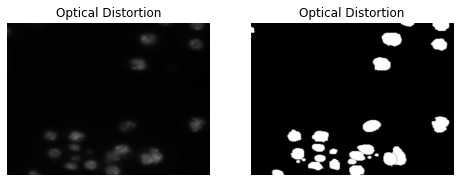

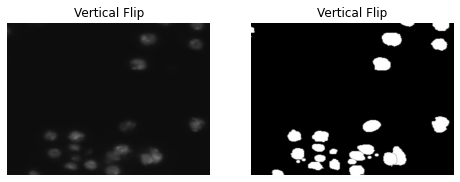

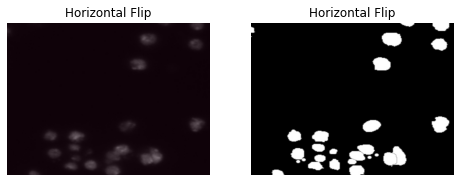

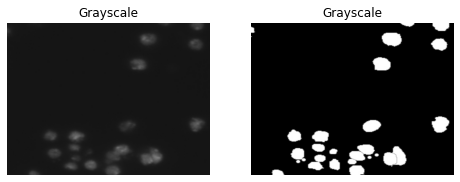

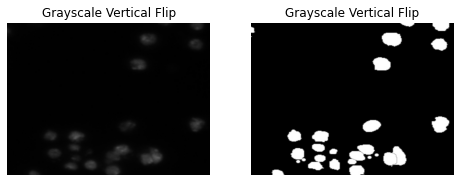

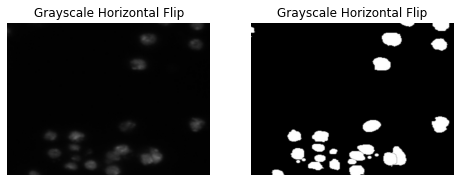

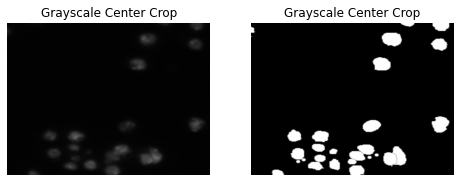

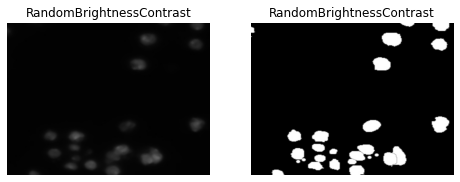

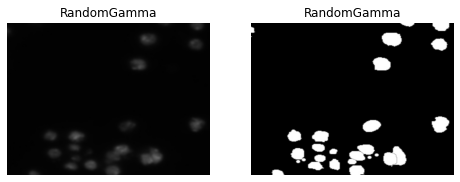

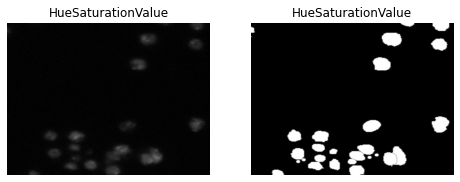

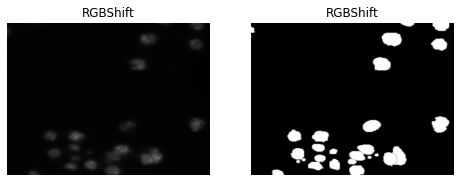

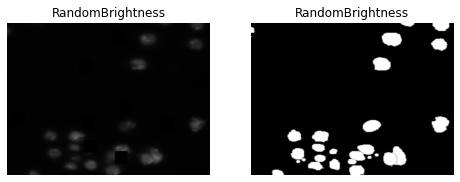

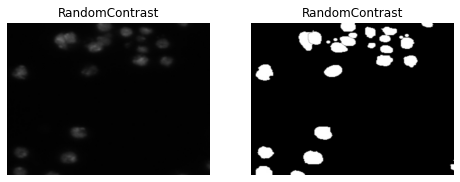

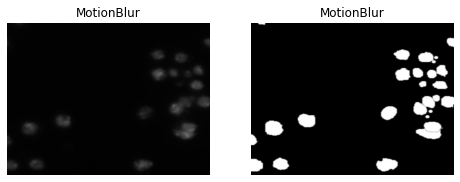

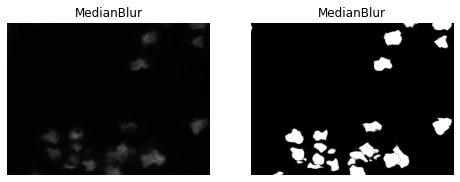

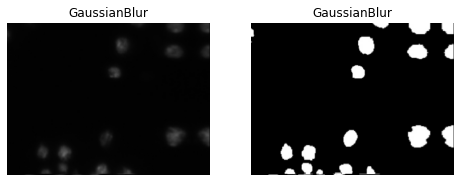

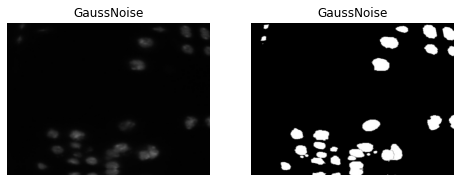

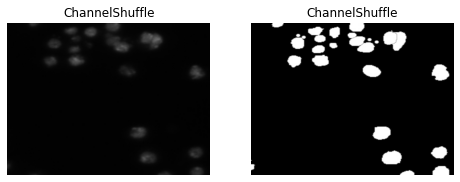

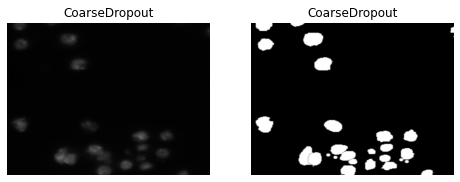

In [20]:
visualise_augmentation("/content/gdrive/MyDrive/Colab Notebooks/vision/double-unet/data/bowl/files/new_data1/train/")

## Bowl

In [62]:
split_augment_data("/content/gdrive/MyDrive/Colab Notebooks/vision/double-unet/data/bowl",images_ids)

here


  0%|          | 0/536 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1828: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1953: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  "blur_limit and sigma_limit minimum value can not be both equal to 0. "
100%|██████████| 67/67 [00:13<00:00,  4.94it/s]


In [63]:
! find "/content/gdrive/MyDrive/Colab Notebooks/vision/double-unet/data/bowl/new_data1/train/mask" -type f | wc -l

13936


In [ ]:
rm -r "/content/gdrive/MyDrive/Colab Notebooks/vision/double-unet/data/bowl/new_data1/"

# PreParing dataset

In [18]:
def parse_data(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        y = np.concatenate([y, y], axis=-1)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([384, 512, 3])
    y.set_shape([384, 512, 2])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=32)
    dataset = dataset.map(map_func=parse_data)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch)
    return dataset

def prepare_train_data(train_path,valid_path,path):
    np.random.seed(42)
    tf.random.set_seed(42)
    # create_dir(path + "/files")

    ## Training
    train_x = sorted(glob(os.path.join(train_path, "image", "*.jpg")))
    train_y = sorted(glob(os.path.join(train_path, "mask", "*.jpg")))

    ## Shuffling
    train_x, train_y = shuffling(train_x, train_y)

    ## Validation
    valid_x = sorted(glob(os.path.join(valid_path, "image", "*.jpg")))
    valid_y = sorted(glob(os.path.join(valid_path, "mask", "*.jpg")))

    return train_x,train_y, valid_x, valid_y

## Bowl

In [19]:
train_x,train_y, valid_x, valid_y = prepare_train_data("/content/gdrive/MyDrive/Colab Notebooks/vision/double-unet/data/bowl/new_data1/train/","/content/gdrive/MyDrive/Colab Notebooks/vision/double-unet/data/bowl/new_data1/valid/","/content/gdrive/MyDrive/Colab Notebooks/vision/double-unet/data/bowl/")

In [20]:
batch_size = 4

In [21]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

In [22]:
len(train_x)

0

# Model

The double-unet model consists of two semi-unet networks as it is shown in the following diagram.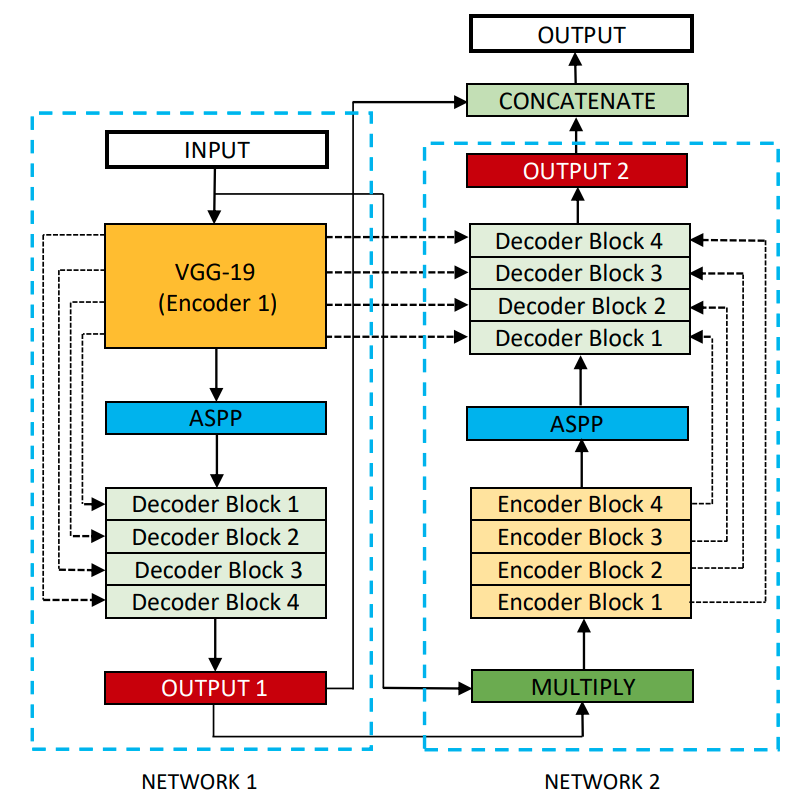

In [6]:
def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x)

    return x

def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same")(inputs)
    x = Activation('sigmoid')(x)
    return x

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

# ===================================== Network 1 =============================================

def encoder1(inputs):
    skip_connections = []

    model = VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, skip_connections

def decoder1(inputs, skip_connections):
    num_filters = [256, 128, 64, 32]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x

# ===================================== Network 2 =============================================

def encoder2(inputs):
    num_filters = [32, 64, 128, 256]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        skip_connections.append(x)
        x = MaxPool2D((2, 2))(x)

    return x, skip_connections

def decoder2(inputs, skip_1, skip_2):
    num_filters = [256, 128, 64, 32]
    skip_2.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_1[i], skip_2[i]])
        x = conv_block(x, f)

    return x

#=============================== double-unet Model ================================

def doubleunet_model(shape):
  # network 1
    inputs = Input(shape)
    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, skip_1)
    outputs1 = output_block(x)
    
  # input to the second network
    x = inputs * outputs1

  # network 2
    x, skip_2 = encoder2(x)
    x = ASPP(x, 64)
    x = decoder2(x, skip_1, skip_2)
    outputs2 = output_block(x)
    outputs = Concatenate()([outputs1, outputs2])

    model = Model(inputs, outputs)
    plot_model(model, to_file='segmentation_model.png', show_shapes=True, show_layer_names=True)
    return model


## Metrics

In [7]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

# Load model

In [8]:
model_base_path = "/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data"
epochs = 50
lr = 1e-4
shape = (384, 512, 3)

In [9]:
model = doubleunet_model(shape)

80150528/80134624 [==============================] - 2s 0us/step


In [10]:
def load_pretrained_model(path):
  metrics = [
        dice_coef,
        iou,
        Recall(),
        Precision()]
  model = tf.keras.models.load_model(path,custom_objects={'dice_loss': dice_loss, 'dice_coef':dice_coef,'iou':iou})
  model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)
  return model

In [11]:
model = load_pretrained_model("/content/gdrive/MyDrive/Colab Notebooks/vision/double-unet/data/bowl/files/"+"model7.h5")

# Train

In [ ]:
def train_model(train_dataset,valid_dataset,train_x,valid_x,batch_size,epochs,path):
  callbacks = [
          ModelCheckpoint("/content/gdrive/MyDrive/Colab Notebooks/vision/double-unet/data/bowl/files/"+"model7.h5"),
          ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20),
          CSVLogger("/content/gdrive/MyDrive/Colab Notebooks/vision/double-unet/data/bowl/files/"+"data7.csv"),
          TensorBoard(),
          EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False)
  ]

  train_steps = (len(train_x)//batch_size)
  valid_steps = (len(valid_x)//batch_size)

  if len(train_x) % batch_size != 0:
        train_steps += 1

  if len(valid_x) % batch_size != 0:
        valid_steps += 1

  model.fit(train_dataset,
              epochs=50,
              initial_epoch = 14,
              validation_data=valid_dataset,
              steps_per_epoch=train_steps,
              validation_steps=valid_steps,
              callbacks=callbacks,
              verbose=1,
              shuffle=False)
  return model

## Bowl

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
model_bowl = train_model(train_dataset,valid_dataset,train_x,valid_x,4,epochs,"/bowl/files/")

Epoch 15/50
3484/3484 [==============================] - 3607s 1s/step - loss: 0.0945 - dice_coef: 0.9055 - iou: 0.8307 - recall: 0.7400 - precision: 0.9618 - val_loss: 0.0833 - val_dice_coef: 0.9167 - val_iou: 0.8471 - val_recall: 0.7223 - val_precision: 0.9811 - lr: 1.0000e-04
Epoch 16/50
3484/3484 [==============================] - 3566s 1s/step - loss: 0.0942 - dice_coef: 0.9058 - iou: 0.8314 - recall: 0.7402 - precision: 0.9626 - val_loss: 0.0810 - val_dice_coef: 0.9190 - val_iou: 0.8515 - val_recall: 0.7492 - val_precision: 0.9705 - lr: 1.0000e-04
Epoch 17/50
3484/3484 [==============================] - 3562s 1s/step - loss: 0.0927 - dice_coef: 0.9073 - iou: 0.8338 - recall: 0.7418 - precision: 0.9638 - val_loss: 0.0877 - val_dice_coef: 0.9123 - val_iou: 0.8406 - val_recall: 0.7730 - val_precision: 0.9557 - lr: 1.0000e-04
Epoch 18/50
3484/3484 [==============================] - 3566s 1s/step - loss: 0.0898 - dice_coef: 0.9102 - iou: 0.8382 - recall: 0.7437 - precision: 0.9651 - v

In [ ]:
model_bowl = train_model(train_dataset,valid_dataset,train_x,valid_x,8,epochs,"/bowl/files/")

Epoch 7/50
1742/1742 [==============================] - 1763s 994ms/step - loss: 0.1026 - dice_coef: 0.8974 - iou: 0.8179 - recall: 0.7301 - precision: 0.9601 - val_loss: 0.0964 - val_dice_coef: 0.9036 - val_iou: 0.8268 - val_recall: 0.7486 - val_precision: 0.9436 - lr: 1.0000e-04
Epoch 8/50
1742/1742 [==============================] - 1743s 1s/step - loss: 0.0997 - dice_coef: 0.9003 - iou: 0.8230 - recall: 0.7360 - precision: 0.9621 - val_loss: 0.1024 - val_dice_coef: 0.8976 - val_iou: 0.8156 - val_recall: 0.7344 - val_precision: 0.9546 - lr: 1.0000e-04
Epoch 9/50
1742/1742 [==============================] - 1744s 1s/step - loss: 0.1016 - dice_coef: 0.8984 - iou: 0.8197 - recall: 0.7306 - precision: 0.9608 - val_loss: 0.1154 - val_dice_coef: 0.8846 - val_iou: 0.7956 - val_recall: 0.7401 - val_precision: 0.9410 - lr: 1.0000e-04
Epoch 10/50
1742/1742 [==============================] - 1729s 992ms/step - loss: 0.0964 - dice_coef: 0.9036 - iou: 0.8280 - recall: 0.7375 - precision: 0.9638 

KeyboardInterrupt: ignored

In [ ]:
model_bowl = train_model(train_dataset,valid_dataset,train_x,valid_x,4,epochs,"/bowl/files/")

Epoch 2/50
3484/3484 [==============================] - 10344s 3s/step - loss: 0.1241 - dice_coef: 0.8759 - iou: 0.7854 - recall: 0.7287 - precision: 0.9495 - val_loss: 0.1122 - val_dice_coef: 0.8878 - val_iou: 0.8009 - val_recall: 0.7126 - val_precision: 0.9646 - lr: 1.0000e-04
Epoch 3/50
 231/3484 [>.............................] - ETA: 2:40:07 - loss: 0.1126 - dice_coef: 0.8874 - iou: 0.8023 - recall: 0.7248 - precision: 0.9542

# Prediction

In [64]:
test_path = "/content/gdrive/MyDrive/Colab Notebooks/vision/double-unet/data/bowl/new_data1/test"

In [65]:
test_x = sorted(glob(os.path.join(test_path, "image", "*.jpg")))
test_y = sorted(glob(os.path.join(test_path, "mask", "*.jpg")))

In [66]:
len(test_x)

67

In [ ]:
model = load_pretrained_model("/content/gdrive/MyDrive/Colab Notebooks/vision/double-unet/data/bowl/files/"+"model7.h5")

In [67]:
def evaluating_model(test_x, test_y):
    np.random.seed(42)
    tf.random.set_seed(42)

    batch_size = 1

    print(len(test_x))
    test_dataset = tf_dataset(test_x, test_y)

    test_steps = (len(test_x)//batch_size)
    if len(test_x) % batch_size != 0:
        test_steps += 1

    # model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/lesion/files/"+"model3.h5",custom_objects={'dice_loss': dice_loss, 'dice_coef':dice_coef,'iou':iou}, compile=False)
    print("evaluate")
    model.evaluate(test_dataset, steps=test_steps)


In [68]:
evaluating_model(test_x, test_y)

67
evaluate
67/67 [==============================] - 143s 2s/step - loss: 0.0809 - dice_coef: 0.9191 - iou: 0.8506 - recall: 0.7619 - precision: 0.9650


# Visualisation

In [14]:
#@title Load model and test set
test_path = "/content/gdrive/MyDrive/Colab Notebooks/vision/double-unet/data/bowl/files/new_data1/test/"
test_x = sorted(glob(os.path.join(test_path, "image", "*.jpg")))
test_y = sorted(glob(os.path.join(test_path, "mask", "*.jpg")))
model = load_pretrained_model("/content/gdrive/MyDrive/Colab Notebooks/vision/double-unet/data/bowl/files/"+"model7.h5")

path is :  /content/gdrive/MyDrive/Colab Notebooks/vision/double-unet/data/bowl/files/new_data1/test/image/356d9903d16074f152fe8f2f0ef555d9959c53264228eae7373cad5cf35d4e85_0.jpg


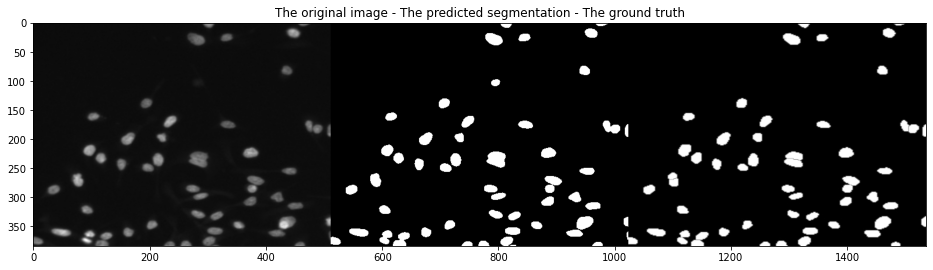

In [16]:
#@title Segment an image
import sklearn
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

size = (512, 384)

def preprocessing(img):
    size = (512, 384)
    img2 = cv2.resize(img, size)
    img2 = np.clip(img2 - np.median(img2)+127, 0, 255)
    img2 = img2.astype(np.float32)

    img2 = img2/255.
    return img2


def get_predict(model, img):
    processed_img = preprocessing(img)
    processed_img = np.expand_dims(processed_img, axis=0)
    out_put = model.predict(processed_img)
    out_put = out_put[..., -1]
    out_put = out_put[0]
    out_put = sklearn.preprocessing.binarize(out_put, threshold=0.5)
    out_put = out_put*255.
    return out_put

#@markdown Choose a number between 1 to 67
index =  19#@param {type:"integer"}

x = test_x[index-1]
y = test_y[index-1]
print("path is : ", x)
img2 = cv2.imread(x, cv2.IMREAD_COLOR)
groundthruth = cv2.imread(y, cv2.IMREAD_COLOR)
out_put = get_predict(model, img2)
out_put = out_put.astype(np.uint8)
out_put = np.stack([out_put, out_put, out_put], axis=-1)
out_put2 = np.concatenate([cv2.resize(img2, size), out_put, groundthruth], axis=1)
# cv2_imshow(out_put2)
plt.figure(figsize=(16, 8))
plt.title("The original image - The predicted segmentation - The ground truth")
plt.imshow(cv2.cvtColor(out_put2, cv2.COLOR_BGR2RGB))